In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

from classes.experiment import Experiment
from classes.agent import Agent

from methods.states_params_importer import import_states_params_asdict
from methods.action_plans import generate_action_plan

%matplotlib inline

In [2]:
## Import behavioural experiment
with open('/mnt/c/Users/vbtes/CompProjects/vbtCogSci/csl_global_analysis/data/global_modelling_data.obj', 'rb') as inFile:
    modelling_data = pickle.load(inFile)

print(len(modelling_data.keys()))

models_dict = import_states_params_asdict()


420


In [3]:
part_key = '5fb91837b8c8756d924f7351'
conditions = ['generic_0', 'congruent', 'incongruent', 'implausible']
cond = conditions[1]

In [4]:
# Model fitting
fit_or_run = False # If false, no data will be used 


part_data = modelling_data[part_key]
part_experiment = part_data['experiment']
trials = part_data['trials']

trial_data = trials[cond]
## Data from trial
model_name = trial_data['name'][:-2]
difficulty = cond
data = trial_data['data'] # Raw numerical data of variable values
ground_truth = trial_data['ground_truth'] # Ground truth model from which data has been generated
#ground_truth = np.array([0, 1, 0, 0, 0, 1])
inters = trial_data['inters'] # Interventions as is
inters_fit = trial_data['inters_fit'] # Interventions with removed movements
judgement_data = trial_data['links_hist'] # Change in judgement sliders
posterior_judgement = trial_data['posterior'] # Final states of judgement sliders
prior_judgement = trial_data['prior'] if 'prior' in trial_data.keys() else None
utid = trial_data['utid']

In [5]:
use_fitted_parameters = True
if use_fitted_parameters:
    with open('./data/params_fitting_outputs/fitted_params.json', 'r') as infile:
        use_fitted_params = json.load(infile)

if use_fitted_params:
    fitted_params_dict = use_fitted_params[part_key] 

internal_states_list = [
    'normative_&_1',
    #'LC_discrete_&_1',
    #'LC_discrete_att_&_att',
    #'change_obs_fk_&_att_cha'
]
sensory_states_list = [
    'omniscient'
]
action_states_list = [
    #'experience_vao',
    #'tree_search_soft_horizon',
    'tree_search_hard_horizon'
]

use_action_plan = None

In [6]:
# Unpack generic trial relevant parameters
N = data.shape[0] - 0 # Number of datapoints
K = data.shape[1] # Number of variable

if use_action_plan:
    if isinstance(use_action_plan, float):
        action_plan = generate_action_plan(N, K, time=use_action_plan)
    elif isinstance(use_action_plan, str):
        action_plan = [trial_data['inters'], trial_data['data']]
    acting_len = (1 - np.isnan(action_plan[0])).mean()
else:
    action_plan = None

# Set up OU netowrk 
external_state = models_dict['external']['OU_Network']['object'](N, K, 
                                                                 *models_dict['external']['OU_Network']['params']['args'],
                                                                 **models_dict['external']['OU_Network']['params']['kwargs'], 
                                                                 ground_truth=ground_truth)

if fit_or_run == 'run':
    external_state.load_trial_data(data) # Load Data

# Set up states
## Internal states and sensory states
internal_states = []
sensory_states = []
for i, model_tags in enumerate(internal_states_list):
    if len(model_tags.split('_&_')) == 2:
        model, tags = model_tags.split('_&_')
    else:
        model = model_tags.split('_&_')[0]

    ## Internal States
    internal_states_kwargs = models_dict['internal'][model]['params']['kwargs'].copy()
    ## Sensory States
    sensory_states_kwargs = models_dict['sensory'][sensory_states_list[i]]['params']['kwargs'].copy()
    # Setup fitted params
    if use_fitted_params and model_tags in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model_tags].items():
            # Internal states params
            if param_key in internal_states_kwargs.keys():
                internal_states_kwargs[param_key] = param_val
            # Sensory states params
            if param_key in sensory_states_kwargs.keys():
                sensory_states_kwargs[param_key] = param_val

    # Set up internal states
    i_s = models_dict['internal'][model]['object'](N, K, 
                                                   *models_dict['internal'][model]['params']['args'],
                                                   **internal_states_kwargs,
                                                   generate_sample_space = True)

    # Initialise prior distributions for all IS
    i_s.initialise_prior_distribution(prior_judgement)
    # Load data if fitting
    if fit_or_run == 'fit':
        i_s.load_judgement_data(judgement_data, posterior_judgement, False)
    
    internal_states.append(i_s)
        
    # Set up sensory states
    sensory_s = models_dict['sensory'][sensory_states_list[i]]['object'](N, K, 
                                                                         *models_dict['sensory'][sensory_states_list[i]]['params']['args'],
                                                                         **sensory_states_kwargs)
    sensory_states.append(sensory_s)

## Action states
action_states = []
for model in action_states_list:
    action_states_kwargs = models_dict['actions'][model]['params']['kwargs'].copy()
    if use_fitted_params and model in fitted_params_dict.keys():
        for param_key, param_val in fitted_params_dict[model].items():
            if param_key in action_states_kwargs.keys():
                action_states_kwargs[param_key] = param_val
    
    a_s = models_dict['actions'][model]['object'](N, K, 
                                                 *models_dict['actions'][model]['params']['args'],
                                                 **action_states_kwargs)
    # Load action data if fitting
    if fit_or_run == 'fit':
        a_s.load_action_data(inters, inters_fit, data)
    else:
        if action_plan:
            a_s.load_action_plan(*action_plan)
        else:
            # If no action plan, behaviour is random
            a_s._behaviour = 'actor' # Can be random or actor

    action_states.append(a_s)

if len(action_states) == 1: # Must be true atm, multiple action states are not supported
    action_states = action_states[0] 


In [7]:
        
# Create agent
if len(internal_states) == 1:
    agent = Agent(N, sensory_states[0], internal_states[0], action_states)
else:
    agent = Agent(N, sensory_states, internal_states, action_states)
# Create experiment
experiment = Experiment(agent, external_state)

In [8]:
# Run experiment
if fit_or_run == 'fit':
    experiment.fit()
else:
    experiment.run()

#experiment.entropy_report()

True model: [-1.  -0.5  1.  -0.5 -0.5 -1. ]
Final MAP: [-1.  -0.5  1.  -0.5 -0.5 -1. ]


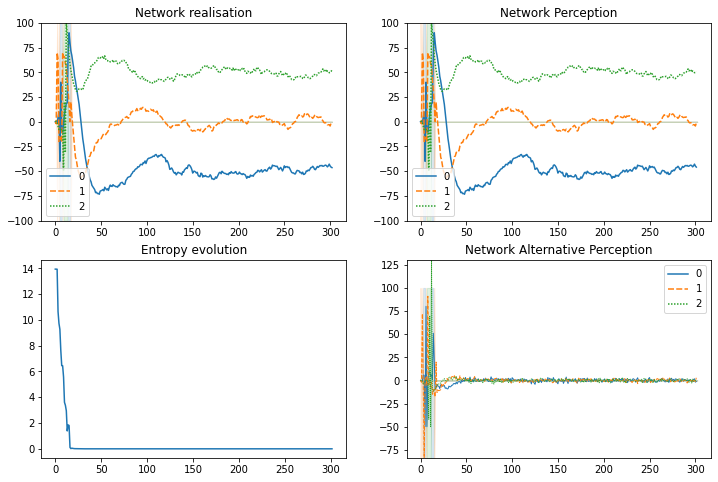

In [9]:
experiment.entropy_report()

In [10]:
np.round(internal_states[0].posterior_unsmoothed, 2)

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
for i in internal_states[0]._posterior_params_history:
    print(i.min(), i.max())

-9.6566274746046 -9.6566274746046
-9.6566274746046 -9.6566274746046
-10.099990045863482 -9.6566274746046
-91.71656889394092 -9.799593331714139
-160.68718884323155 -9.875584825426696
-162.67150072083749 -10.397218696294898
-188.7574646298493 -11.417896316645988
-213.24835140471194 -13.36608430391026
-216.905108696632 -14.275509440284292
-297.12027845729517 -14.354609439198386
-442.14201611333544 -16.56060411492658
-476.57144941461286 -16.63463194128942
-541.9180383619525 -17.08035758701273
-699.6223060166583 -17.08035758701273
-824.9970220625055 -20.139402051792864
-1098.2509656717034 -21.28665703277791
-1467.8197547767809 -21.485944465628975
-1519.7751024474828 -21.499223348895164
-1729.5978836082218 -23.905172141184593
-1901.0335095018181 -24.232284677906893
-2060.814836193659 -24.298717989417277
-2216.4915980155915 -25.9820120329695
-2338.856082593874 -26.898437880538303
-2412.4051729372036 -29.400691190915566
-2507.702431186475 -29.476292666432553
-2601.78647473364 -29.9441647796683

# Fitting

When fitting, we have data about the external states, the interventions a participant made, i.e. action states, and their judgement or any other direct measure of their internal states. 

By definition, sensory states are never observed because they are always implicit. In many cases such as in a control environment, internal states will not be directly observed using judgement but should be inferred from actions states

The dependencies between all core modules imply that fitting a dataset of observations, actions and judgments is only valid for the current global parametrisation of the agent, i.e. the collection of internal, sensory and action states. We can compare how things change when changing one of the modules but we cannot seperate the likelihoods over the different modules.

## Where should the data be stored when fitting?

Basically the question is programming related and asks how should the data be split when initialising the states of the experiment. It could be a seperate method "load_data" called seperately from initialising the agent and the external states. Given the current way the states objects are structured, it creates an inconsistency where parameters have to be specified before hand before being overwritten.

# Questions

## Number of datapoints

The log likelihood is highly sensitive to the number of datapoints. If we assume that the participant cannot observe all datapoints for instance, we artificially reduce the log likelihood. So what can we do?

What do we do when encountering negative infinities, i.e. probability 0. Conceptually it can make sense but it is still highly dependent on the number of datapoints again as some discrete models will simply converge numerically to point masses given enough datapoints. Can we simply conclude to the extreme unlikeliness of this model?

## Number of parameters

Also the number of parameters in a model is not straightforward: in the discrete case model representation has 15625 and links representation has 30, but one is a direct function of the other without adding any additional parameters. In a continuous case, easier to represent as it is the collection of parameters of the PDF.